<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Budget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## El Caso: Predicción de Cumplimiento de Producción (Budget Variance)

# En la planificación, el modelo geológico dice que hay $X$ ley de cobre, pero al minar, la realidad suele ser diferente. Usaremos ML para predecir esa desviación.

# 1. Preparación de Datos de Planeamiento (data simulada)

import pandas as pd
import numpy as np

np.random.seed(42)
n_meses = 2400 # 200 meses de datos simulados por 12 tajos/fases

data_plan = {
    'Fase_Minado': np.random.randint(1, 5, n_meses),
    'Ley_Cu_Planificada': np.random.uniform(0.4, 1.1, n_meses),
    'Dureza_SPI': np.random.uniform(60, 120, n_meses), # Resistencia del mineral
    'Distancia_Acarreo_km': np.random.uniform(1.5, 5.0, n_meses),
    'Disponibilidad_Flota_pct': np.random.uniform(80, 95, n_meses),
    'Precipitacion_mm': np.random.uniform(0, 40, n_meses) # Clima afecta la producción
}

df_plan = pd.DataFrame(data_plan)

# Creamos el target: Tonelaje Real vs Budget (1 = Cumple Budget, 0 = No Cumple)
# La lógica: Si hay mucha lluvia, roca dura y acarreo largo, es probable que no se cumpla el plan.
df_plan['Cumplimiento_Budget'] = np.where(
    (df_plan['Dureza_SPI'] > 100) & (df_plan['Precipitacion_mm'] > 20) |
    (df_plan['Disponibilidad_Flota_pct'] < 83), 0, 1
)

print("✅ Datos de Planeamiento y Producción generados.")
df_plan.head()


✅ Datos de Planeamiento y Producción generados.


,Fase_Minado,Ley_Cu_Planificada,Dureza_SPI,Distancia_Acarreo_km,Disponibilidad_Flota_pct,Precipitacion_mm,Cumplimiento_Budget
0,3,0.930784,68.473413,3.768899,87.485543,14.048681,1
1,4,0.417211,94.252645,2.103352,93.973026,33.489600,1
2,1,0.415486,71.116221,4.553381,88.749994,2.671883,1
3,3,0.626527,76.718584,3.645907,88.075763,37.693740,1
4,3,0.742050,73.122588,2.050214,86.817241,39.452674,1


In [2]:
# Metodología Aplicada al Planeamiento
# Análisis de Importancia de Variables (Feature Importance). Esto le dice al Gerente de Planeamiento qué factor está arruinando su presupuesto.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Variables predictoras
X = df_plan.drop(['Cumplimiento_Budget', 'Fase_Minado'], axis=1)
y = df_plan['Cumplimiento_Budget']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model_budget = RandomForestClassifier(n_estimators=100, random_state=42)
model_budget.fit(X_train, y_train)

# Evaluación
print("--- REPORTE DE CUMPLIMIENTO DE PLAN (BUDGET) ---")
print(classification_report(y_test, model_budget.predict(X_test)))

--- REPORTE DE CUMPLIMIENTO DE PLAN (BUDGET) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       324

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



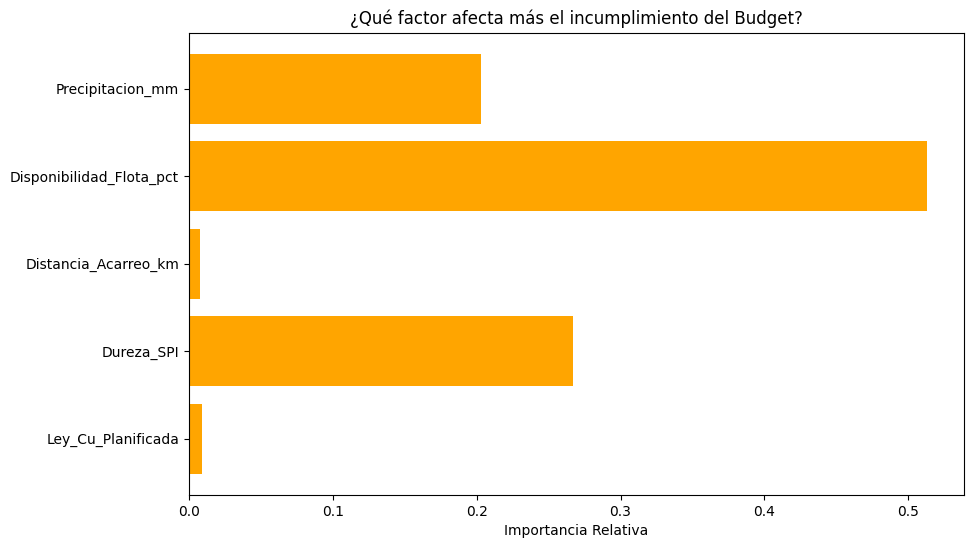

In [3]:
## Visualización de la Importancia (Key Driver Analysis)
import matplotlib.pyplot as plt

importancias = model_budget.feature_importances_
nombres_vars = X.columns

plt.figure(figsize=(10, 6))
plt.barh(nombres_vars, importancias, color='orange')
plt.title('¿Qué factor afecta más el incumplimiento del Budget?')
plt.xlabel('Importancia Relativa')
plt.show()

In [4]:
## Aplicación Práctica: Pronóstico Trimestral (Regresión)

# "si cumple o no" (Clasificación) a predecir cuántas Toneladas de Cobre Fino saldrán realmente.

from sklearn.ensemble import RandomForestRegressor

# Creamos la variable objetivo numérica: Tonelaje Real de Cu
# Lógica: (Tonelaje Base * Disponibilidad) - (Penalidad por Dureza)
df_plan['Tonelaje_Cu_Real'] = (df_plan['Ley_Cu_Planificada'] * 5000 * (df_plan['Disponibilidad_Flota_pct']/100)) - (df_plan['Dureza_SPI'] * 2)

X_reg = df_plan[['Ley_Cu_Planificada', 'Dureza_SPI', 'Distancia_Acarreo_km', 'Disponibilidad_Flota_pct', 'Precipitacion_mm']]
y_reg = df_plan['Tonelaje_Cu_Real']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

model_tonelaje = RandomForestRegressor(n_estimators=100, random_state=42)
model_tonelaje.fit(X_train_r, y_train_r)

print(f"Precisión del Pronóstico de Producción (R2): {model_tonelaje.score(X_test_r, y_test_r):.4f}")

Precisión del Pronóstico de Producción (R2): 0.9987
